# Set up environment

In [1]:
# load the required packages
library(tidyverse)
library(stringr)
library(gage)
library(DESeq2)
library(pheatmap)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,


```
Your Folder Structure:  
└── HTS2018  
    ├── out  
    │   └── hts-pilot-2018.RData  
    |   └── HTS-Pilot-Annotated-STAR-counts.RData
    └── Info
        ├── pathway_genes.txt
        └── pathway_names.txt
```

In [2]:
# set directories
infdir <- "/home/jovyan/work/HTS2018/Info"
outdir <- "/home/jovyan/work/HTS2018/out"

In [3]:
dir(infdir)

[1] "pathway_genes.txt" "pathway_names.txt"

In [4]:
dir(outdir)

[1] "hts_pilot_2018_count_entrez.tsv"      
[2] "hts-pilot-2018.RData"                 
[3] "HTS-Pilot-Annotated-STAR-counts.RData"

-----

# Read in data

## Import count table

```
### Step 0. Attach count data (from KO's STAR pipeline)
### Be sure to first run
### $ R CMD BATCH demodata.R
### to create R object with count data
### This must be replaced with the count data from the
### "official" pipeline (ask Josh if unsure)
### The relevant object names are countData and columnData
### These are based on the aggregating the counts over the
### four lanes
demofile <- "HTS-2018-pilot-demo-data.RData"
attach(demofile)
tools::md5sum(demofile)
```

In [5]:
attach(file.path(outdir, "HTS-Pilot-Annotated-STAR-counts.RData"))
head(annogenecnts0)

gene,1_MA_J,1_RZ_J,10_MA_C,10_RZ_C,11_MA_J,11_RZ_J,12_MA_P,12_RZ_P,13_MA_J,⋯,4_RZ_P,4_TOT_P,40_MA_J,40_RZ_J,45_MA_P,45_RZ_P,47_MA_P,47_RZ_P,9_MA_C,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,265,204,269,76,130,92,205,64,308,⋯,51,13,519,235,410,122,534,112,217,106
CNAG_00003,112,40,171,24,124,18,150,34,221,⋯,11,8,218,53,232,46,240,41,128,35
CNAG_00004,301,207,407,141,272,179,351,156,533,⋯,50,36,719,442,518,238,622,277,310,234
CNAG_00005,114,125,50,25,38,32,38,12,202,⋯,25,14,344,270,202,81,256,118,45,40
CNAG_00006,1904,1295,3571,1015,2073,1327,3003,926,1660,⋯,319,110,3002,1535,3934,1090,4966,1132,3313,1509


-----

## Import pathway information

```
### <Original code>
### Step 1. Prepare a gene set (this is off course a dummy gene
### set consisting of 4 dummy gene sets (object name is mygenesets)

dummygsetfile <- "dummygeneset.R"
source(dummygsetfile)
tools::md5sum(dummygsetfile)
```

Read in the names and gene lists

In [6]:
pathname <- read_tsv(file.path(infdir, "pathway_names.txt"), col_names = FALSE) 
pathgene <- read_tsv(file.path(infdir, "pathway_genes.txt"), col_names = FALSE)

colnames(pathname) <- "path_id"
colnames(pathgene) <- "genelist"

Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)


Observe the pathway information

In [7]:
head(pathname, 3)

path_id
ec00010
ec00020
ec00030


In [9]:
head(pathgene, 2)

genelist
CNAG_00038 | CNAG_00057 | CNAG_00515 | CNAG_00735 | CNAG_00797 | CNAG_01078 | CNAG_01120 | CNAG_01675 | CNAG_01820 | CNAG_01955 | CNAG_02035 | CNAG_02377 | CNAG_02489 | CNAG_02736 | CNAG_02903 | CNAG_03072 | CNAG_03358 | CNAG_03916 | CNAG_04217 | CNAG_04523 | CNAG_04659 | CNAG_04676 | CNAG_05059 | CNAG_05113 | CNAG_06035 | CNAG_06313 | CNAG_06628 | CNAG_06699 | CNAG_06770 | CNAG_07004 | CNAG_07316 | CNAG_07559 | CNAG_07660 | CNAG_07745
CNAG_00061 | CNAG_00747 | CNAG_01120 | CNAG_01264 | CNAG_01657 | CNAG_01680 | CNAG_02736 | CNAG_03225 | CNAG_03226 | CNAG_03266 | CNAG_03375 | CNAG_03596 | CNAG_03674 | CNAG_03920 | CNAG_04189 | CNAG_04217 | CNAG_04468 | CNAG_04535 | CNAG_04640 | CNAG_05059 | CNAG_05236 | CNAG_05907 | CNAG_07004 | CNAG_07356 | CNAG_07363 | CNAG_07660 | CNAG_07851 | CNAG_07944


### Convert the pathway information into a list object

In [11]:
mygenesets = str_split(pathgene$genelist, '\\|')
mygenesets <- lapply(mygenesets, str_trim)
names(mygenesets) = pathname$path_id

In [12]:
length(mygenesets)

[1] 1859

-----

# Creat DESeq object

Observe the count matrix

In [13]:
head(annogenecnts0)

gene,1_MA_J,1_RZ_J,10_MA_C,10_RZ_C,11_MA_J,11_RZ_J,12_MA_P,12_RZ_P,13_MA_J,⋯,4_RZ_P,4_TOT_P,40_MA_J,40_RZ_J,45_MA_P,45_RZ_P,47_MA_P,47_RZ_P,9_MA_C,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,265,204,269,76,130,92,205,64,308,⋯,51,13,519,235,410,122,534,112,217,106
CNAG_00003,112,40,171,24,124,18,150,34,221,⋯,11,8,218,53,232,46,240,41,128,35
CNAG_00004,301,207,407,141,272,179,351,156,533,⋯,50,36,719,442,518,238,622,277,310,234
CNAG_00005,114,125,50,25,38,32,38,12,202,⋯,25,14,344,270,202,81,256,118,45,40
CNAG_00006,1904,1295,3571,1015,2073,1327,3003,926,1660,⋯,319,110,3002,1535,3934,1090,4966,1132,3313,1509


Observe the metadata

In [14]:
head(annomapres0)

Label,Strain,Media,experiment_person,libprep_person,enrichment_method,prob.gene,prob.nofeat,prob.unique,depth
1_MA_J,H99,YPD,S,J,MA,0.9641456,0.008161923,0.9723075,2493464
1_RZ_J,H99,YPD,S,J,RZ,0.6689001,0.217095621,0.8859957,3541358
10_MA_C,mar1d,YPD,S,C,MA,0.9618651,0.009818573,0.9716837,3282785
10_RZ_C,mar1d,YPD,S,C,RZ,0.7497438,0.200651686,0.9503955,1742594
11_MA_J,mar1d,YPD,S,J,MA,0.9669597,0.008717898,0.9756776,2062181
11_RZ_J,mar1d,YPD,S,J,RZ,0.7030020,0.195547151,0.8985491,2621913


Prepare columnData (DataFrameand countData (matrix object). Let's select samples from RZ

In [15]:
annomapres0 %>%
    dplyr::filter(enrichment_method == "RZ")  %>%
    DataFrame ->
    columnData
rownames(columnData) <- columnData[["Label"]]

### the code below show you the sample that will be analyzed in this example
annogenecnts0 %>%
    dplyr::select(dput(as.character(c("gene",columnData[["Label"]])))) %>%
    as.data.frame %>%
    column_to_rownames("gene") %>%
    as.matrix ->
    countData

c("gene", "1_RZ_J", "10_RZ_C", "11_RZ_J", "12_RZ_P", "13_RZ_J", 
"14_RZ_C", "15_RZ_C", "16_RZ_P", "2_RZ_C", "21_RZ_C", "22_RZ_C", 
"23_RZ_J", "24_RZ_J", "26_RZ_C", "27_RZ_P", "3_RZ_J", "35_RZ_P", 
"36_RZ_J", "38_RZ_P", "4_RZ_P", "40_RZ_J", "45_RZ_P", "47_RZ_P", 
"9_RZ_C")


Conduct DESeq2 Differential Expression (DE) Analysis

In [16]:
### Make DESeq2 data object
dds <- DESeq2::DESeqDataSetFromMatrix(countData, columnData,  ~ Media + Strain + Media:Strain)
### Conduct DE analysis
dds <- DESeq2::DESeq(dds)
### Rlog "normalized" expressions
rld <- rlog(dds)
### Get results from DESeq2 DE analysis
ddsres <- DESeq2::results(dds, contrast = c("Media", "YPD" , "TC"))
### Extract the estimated fold changes
ddsfc <- ddsres$log2FoldChange
### Assign the gene name to the fold change vector
names(ddsfc) <- rownames(ddsres)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


# Pathway analysis performed using gage package

Calculate pathway level statistics using the gage package

In [21]:
### Notes
### This example is using the estimated fold changes for DESeq2 for the inference
### Accordingly, use.fold is set to TRUE and the indices for the ref and target
### samples are set to NULL. The theory behind using fold changes is iffy
### Also, it puts limits on min and max on gene set sizes. This is a tuning parameter
### and our choices are arbitrary.
### Finally, it tests whether within a gene set the genes point in the same direction

gageres <- gage::gage(ddsfc,
                      gsets = mygenesets,
                      use.fold = TRUE,
                      ref = NULL, 
                      samp = NULL,  
                      set.size = c(10, 500),
                      same.dir = TRUE) 


In [22]:
### Geneset analysis using the "microarray" approach. We will use rlog
### transformed expressions for the purpose of this demonstration

gageres <- gage::gage(assay(rld),
                      gsets = mygenesets,
                      use.fold = FALSE,
                      ref = which(colData(rld)[["Media"]]=="TC"), 
                      samp = which(colData(rld)[["Media"]]=="YPD"),
                      compare = "unpaired",
                      set.size = c(10, 500),
                      same.dir = TRUE) 

----

# Visualization
Draw some heatmaps

### Choose the pathway you are interested

In [23]:
pathid <- "ec00010"

### Plot the heatmap of the expression value

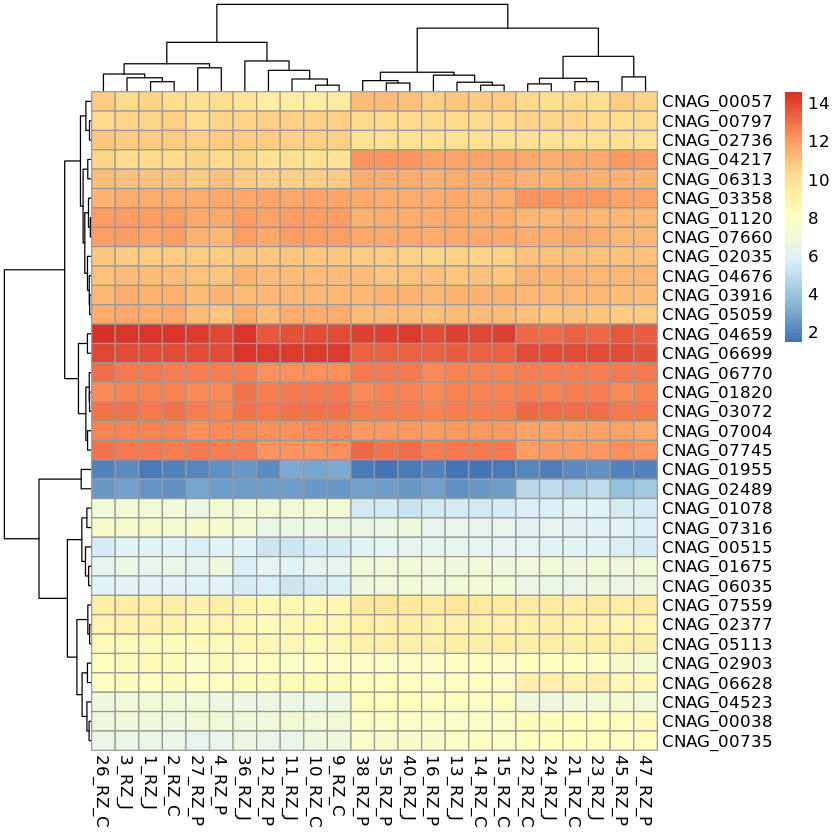

In [24]:
### Heatmap for geneset 1 based on rlog transformed "expressions"
pheatmap(assay(rld)[mygenesets[[pathid]],])

Of couse, you need to convert the expression of each gene into the same scale to compare them across different samples

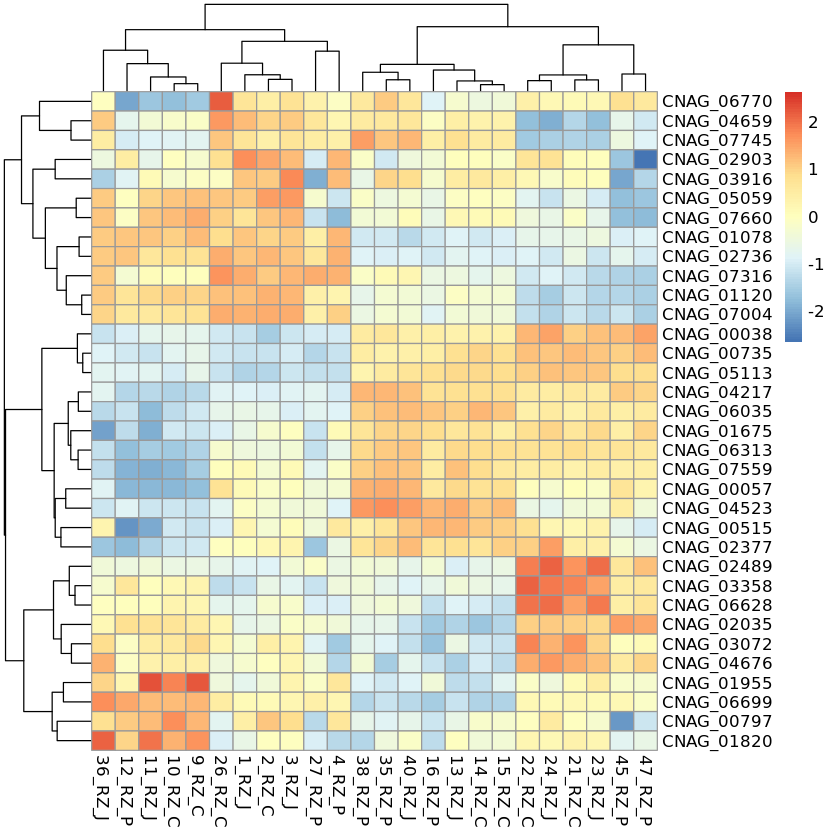

In [25]:
### Be sure to scale across the rows
pheatmap(assay(rld)[mygenesets[[pathid]],], scale = "row")

The pheatmap function allow you add annotation of samples on the heatmap. It also allow you to control the things (title, legend, dendrogram, etc) you want to show.

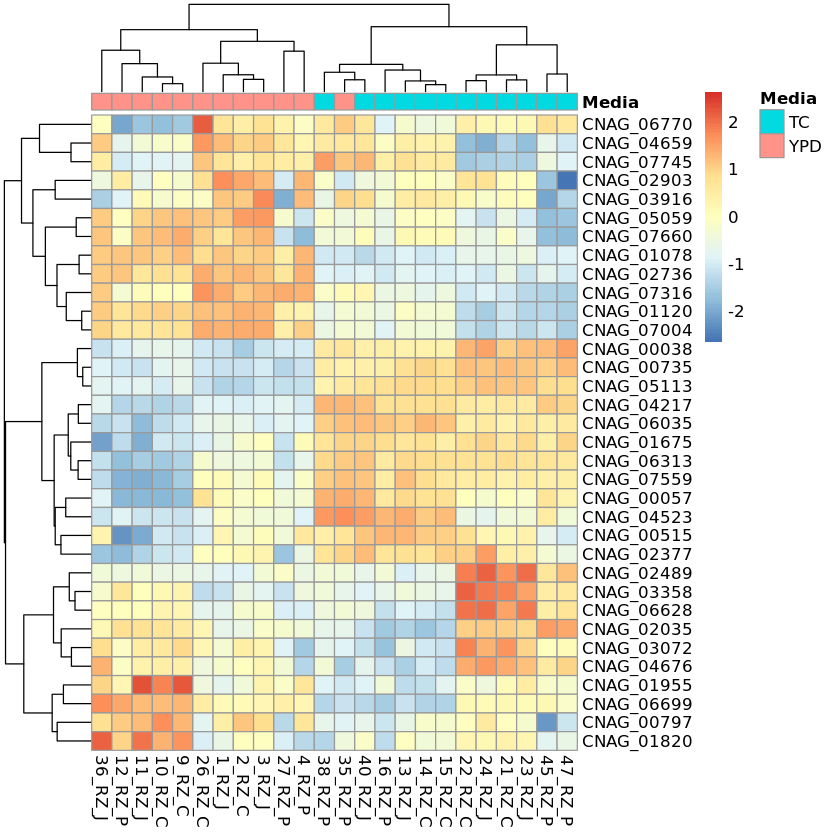

In [26]:
### Annotate heatmap with Media status
annodf <- as.data.frame(colData(rld)[,"Media", drop=FALSE])
pheatmap(assay(rld)[mygenesets[[pathid]],],
         scale = "row",
         annotation_col = annodf)


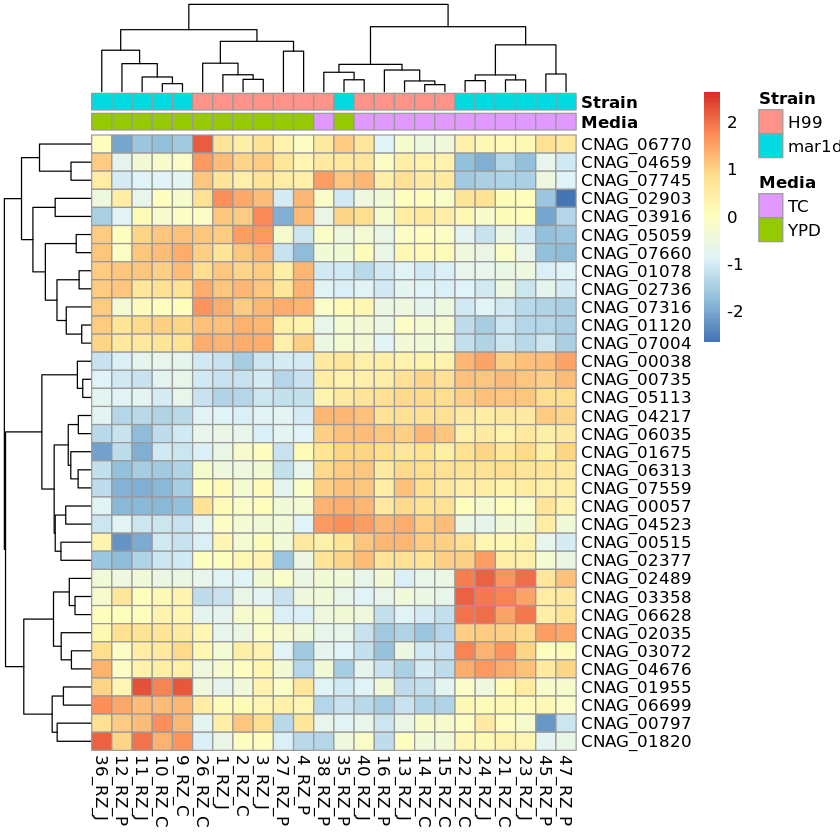

In [27]:
### Annotate heatmap with Media and Strain status
annodf <- as.data.frame(colData(rld)[,c("Media", "Strain"), drop=FALSE])
pheatmap(assay(rld)[mygenesets[[pathid]],],
         scale = "row",
         annotation_col = annodf)


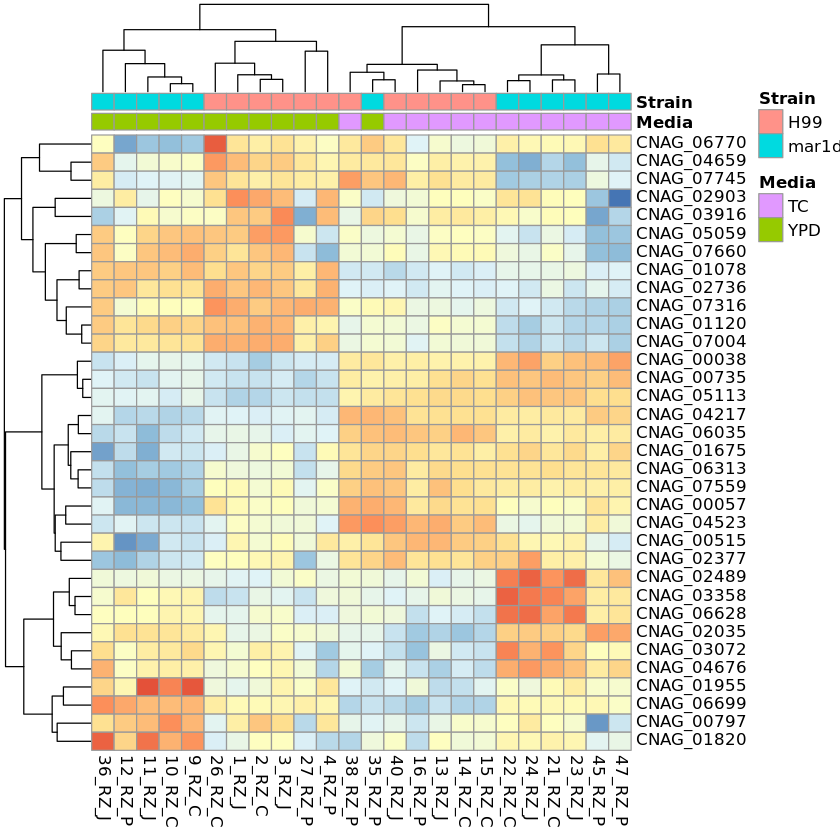

In [28]:
### Add main title and drop legend
annodf <- as.data.frame(colData(rld)[,c("Media", "Strain"), drop=FALSE])
pheatmap(assay(rld)[mygenesets[[pathid]],],
         scale = "row",
         annotation_col = annodf,
         legend = FALSE)

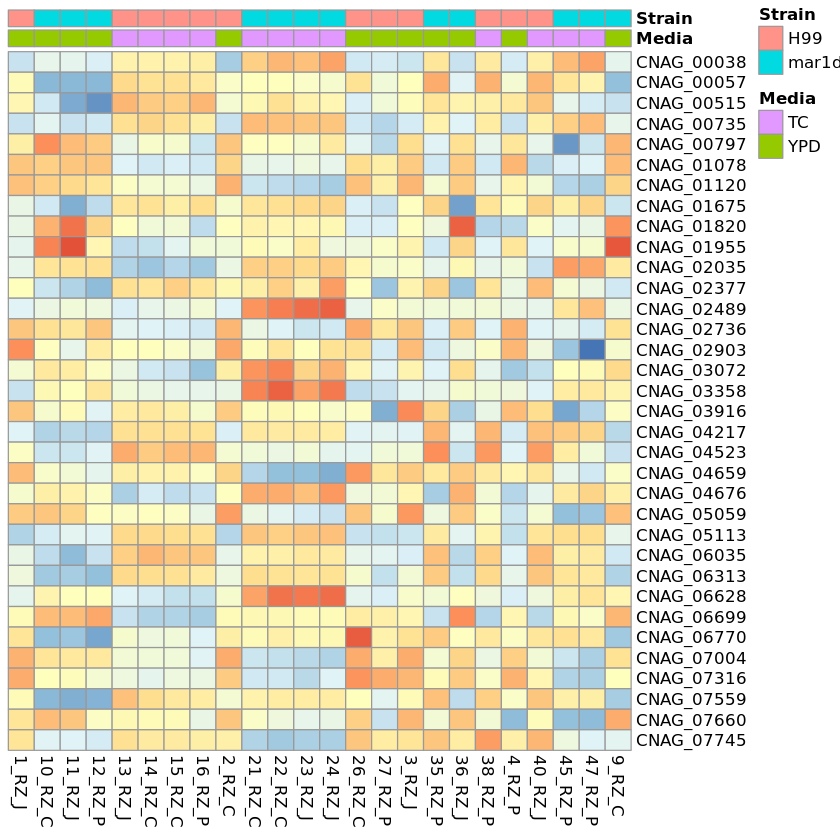

In [29]:
### Add main title, drop legend and disable clustering on columns and rows
annodf <- as.data.frame(colData(rld)[,c("Media", "Strain"), drop=FALSE])
pheatmap(assay(rld)[mygenesets[[pathid]],],
         scale = "row",
         annotation_col = annodf,
         legend = FALSE,
         cluster_rows = FALSE,
         cluster_cols = FALSE)